In [18]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import astropy.constants as c

%matplotlib inline

In [19]:
ticid = 277479500
starName = "TIC " + str(ticid)
search_result = lk.search_targetpixelfile(starName)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 67,2023,SPOC,20,277479500,0.0
1,TESS Sector 67,2023,SPOC,120,277479500,0.0
2,TESS Sector 67,2023,TESS-SPOC,200,277479500,0.0


In [20]:
tpf = search_result[1].download(quality_bitmask='hard')

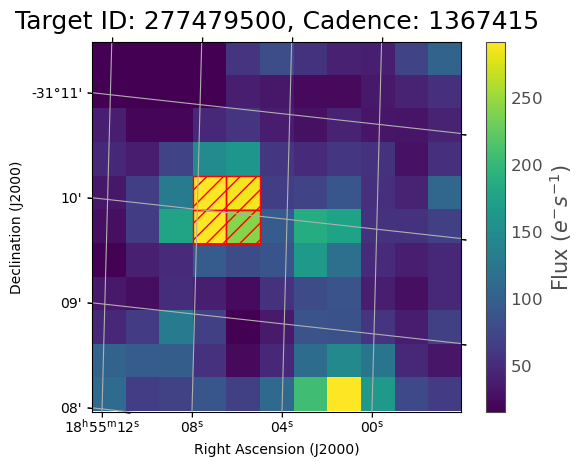

In [21]:
aperture_mask = tpf.create_threshold_mask(threshold=4)

fig, ax = plt.subplots(subplot_kw={'projection': tpf.wcs})  # Use WCS projection
tpf.plot(ax=ax, aperture_mask=aperture_mask)  # Plot TPF imag

#Label axes with RA/Dec
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.show()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

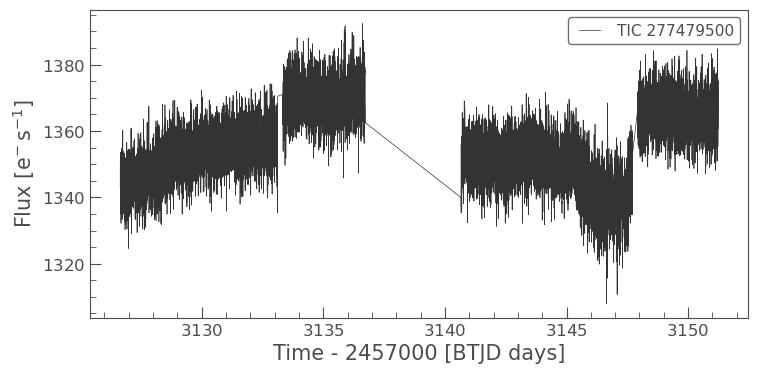

In [22]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
mask = np.full(tpf.shape[0],fill_value=True)
mask[uncorrected_lc.flux.value>5000]=False

mask = mask*(~np.isnan(uncorrected_lc.flux))

uncorrected_lc_clean = uncorrected_lc[mask]
uncorrected_lc_clean.plot()

(14345, 117)


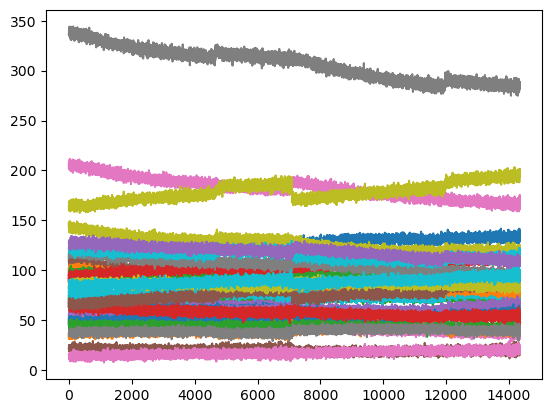

In [23]:
regressors = tpf.flux[:, ~aperture_mask][mask]
print(regressors.shape)
plt.plot(regressors[:, :30]);

In [24]:
from lightkurve.correctors import DesignMatrix
dm = DesignMatrix(regressors, name='regressors')
dm

regressors DesignMatrix (14345, 117)

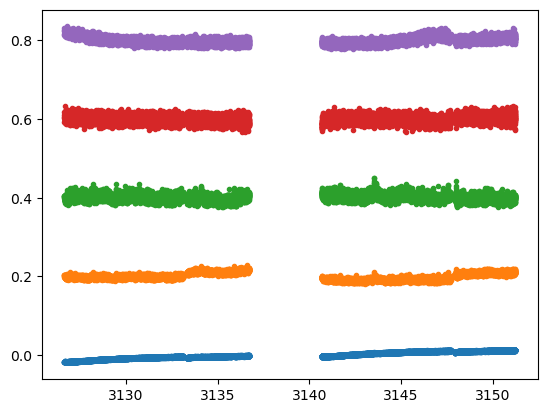

In [25]:
dm = dm.pca(5)
plt.plot(uncorrected_lc_clean.time.value, dm.values + np.arange(5)*0.2, '.');

In [26]:
dm = dm.append_constant()

In [27]:
from lightkurve.correctors import RegressionCorrector
corrector = RegressionCorrector(uncorrected_lc_clean)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

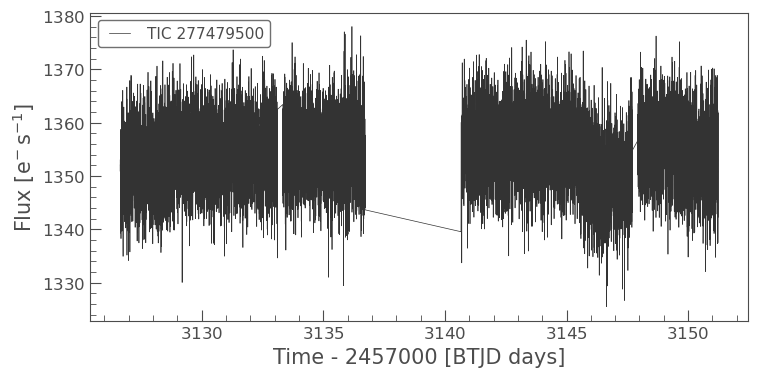

In [28]:
corrected_lc = corrector.correct(dm)
corrected_lc.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

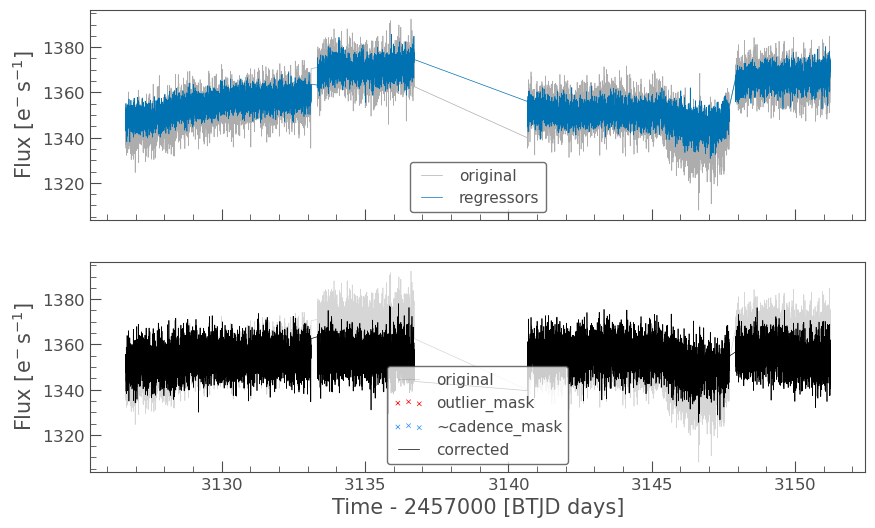

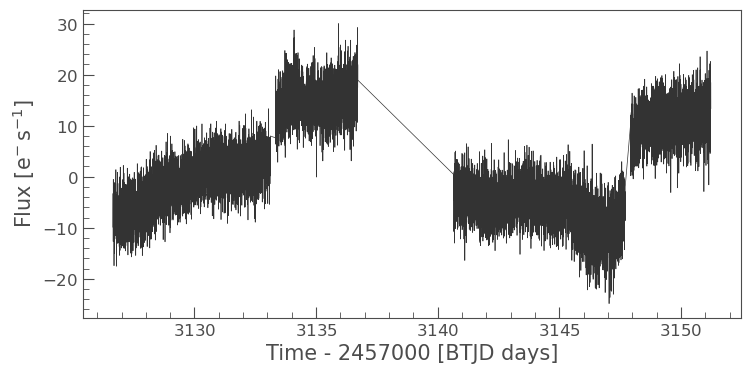

In [29]:
corrector.diagnose()
model = corrector.model_lc
model.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

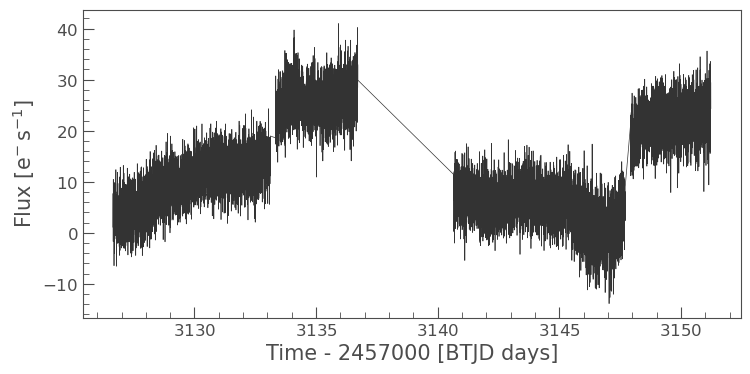

In [30]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)
model.plot()

In [31]:
corrected_lc = uncorrected_lc_clean - model

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

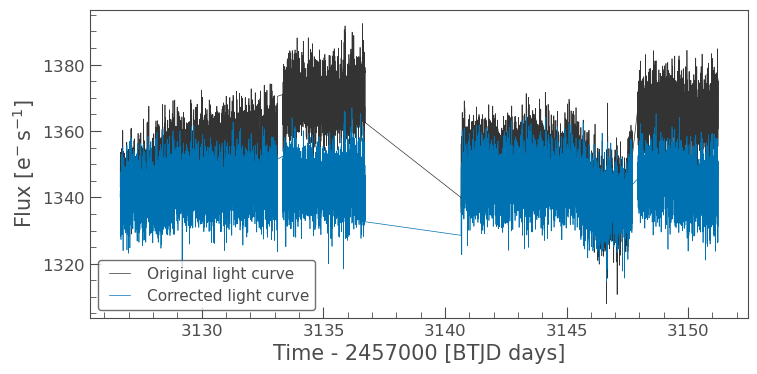

In [32]:
ax = uncorrected_lc_clean.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve')

In [33]:
time_btjd = tpf.time.value

time_jd = time_btjd + 2457000

# Convert to a readable format (e.g., ISO)
from astropy.time import Time
time_iso = Time(time_jd, format='jd').iso

print(time_iso[0]) 
print(time_iso[-1])

2023-07-01 03:33:02.756
2023-07-27 22:48:23.190


In [34]:
a = corrected_lc.time.value
b = corrected_lc.flux.value
c = corrected_lc.flux_err.value

v1223sag1 = np.vstack([a,b,c])

np.savetxt("v1223sag1.csv", v1223sag1, delimiter=",", fmt="%s")